I have used the following methods.

* I have implemented YOLOV8 model stemmed from this Keras example[1,2],
* Used tf.data for input pipeline,
* I created txt file parser function,
 
## My Another Segmentation Projects

* [Sport Scene Classification w/ViT (3 KFold CV)](https://www.kaggle.com/code/banddaniel/sport-scene-classification-w-vit-3-kfold-cv)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain Tumor Segmentation (detectron2, mAP@50:76.2)](https://www.kaggle.com/code/banddaniel/brain-tumor-segmentation-detectron2-map-50-76-2)

## References
1. https://keras.io/examples/vision/yolov8/
2. Reis, D., Kupec, J., Hong, J., & Daoudi, A. (2023). Real-Time Flying Object Detection with YOLOv8 (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2305.09972

In [1]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv


BATCH_SIZE = 4
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# <span style="color:#e74c3c;"> </span> Preprocessing

In [2]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')
    
    boxes = []
    classes = []
    
    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])
        
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
        
            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)
    
            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)
    
    return img_path, classes, boxes


# a function for creating file paths list 
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


class_ids = ['label0', 'label1', 'label2']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

class_mapping

{0: 'label0', 1: 'label1', 2: 'label2'}

In [3]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):
    
    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)
    
    image_paths = []
    bbox = []
    classes = []
    
    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)
        
    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    
    return image_paths, classes, bbox

In [4]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files('/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/train/images', 
                                                              '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/valid/images', 
                                                              '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/test/images', 
                                                            '/kaggle/input/medical-image-dataset-brain-tumor-detection/Brain Tumor Detection/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [5]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32) 
    
    return img


resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.8, 1.25),
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }
    
    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [6]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls = AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls = AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [7]:
# a function to visualize samples from a dataset

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

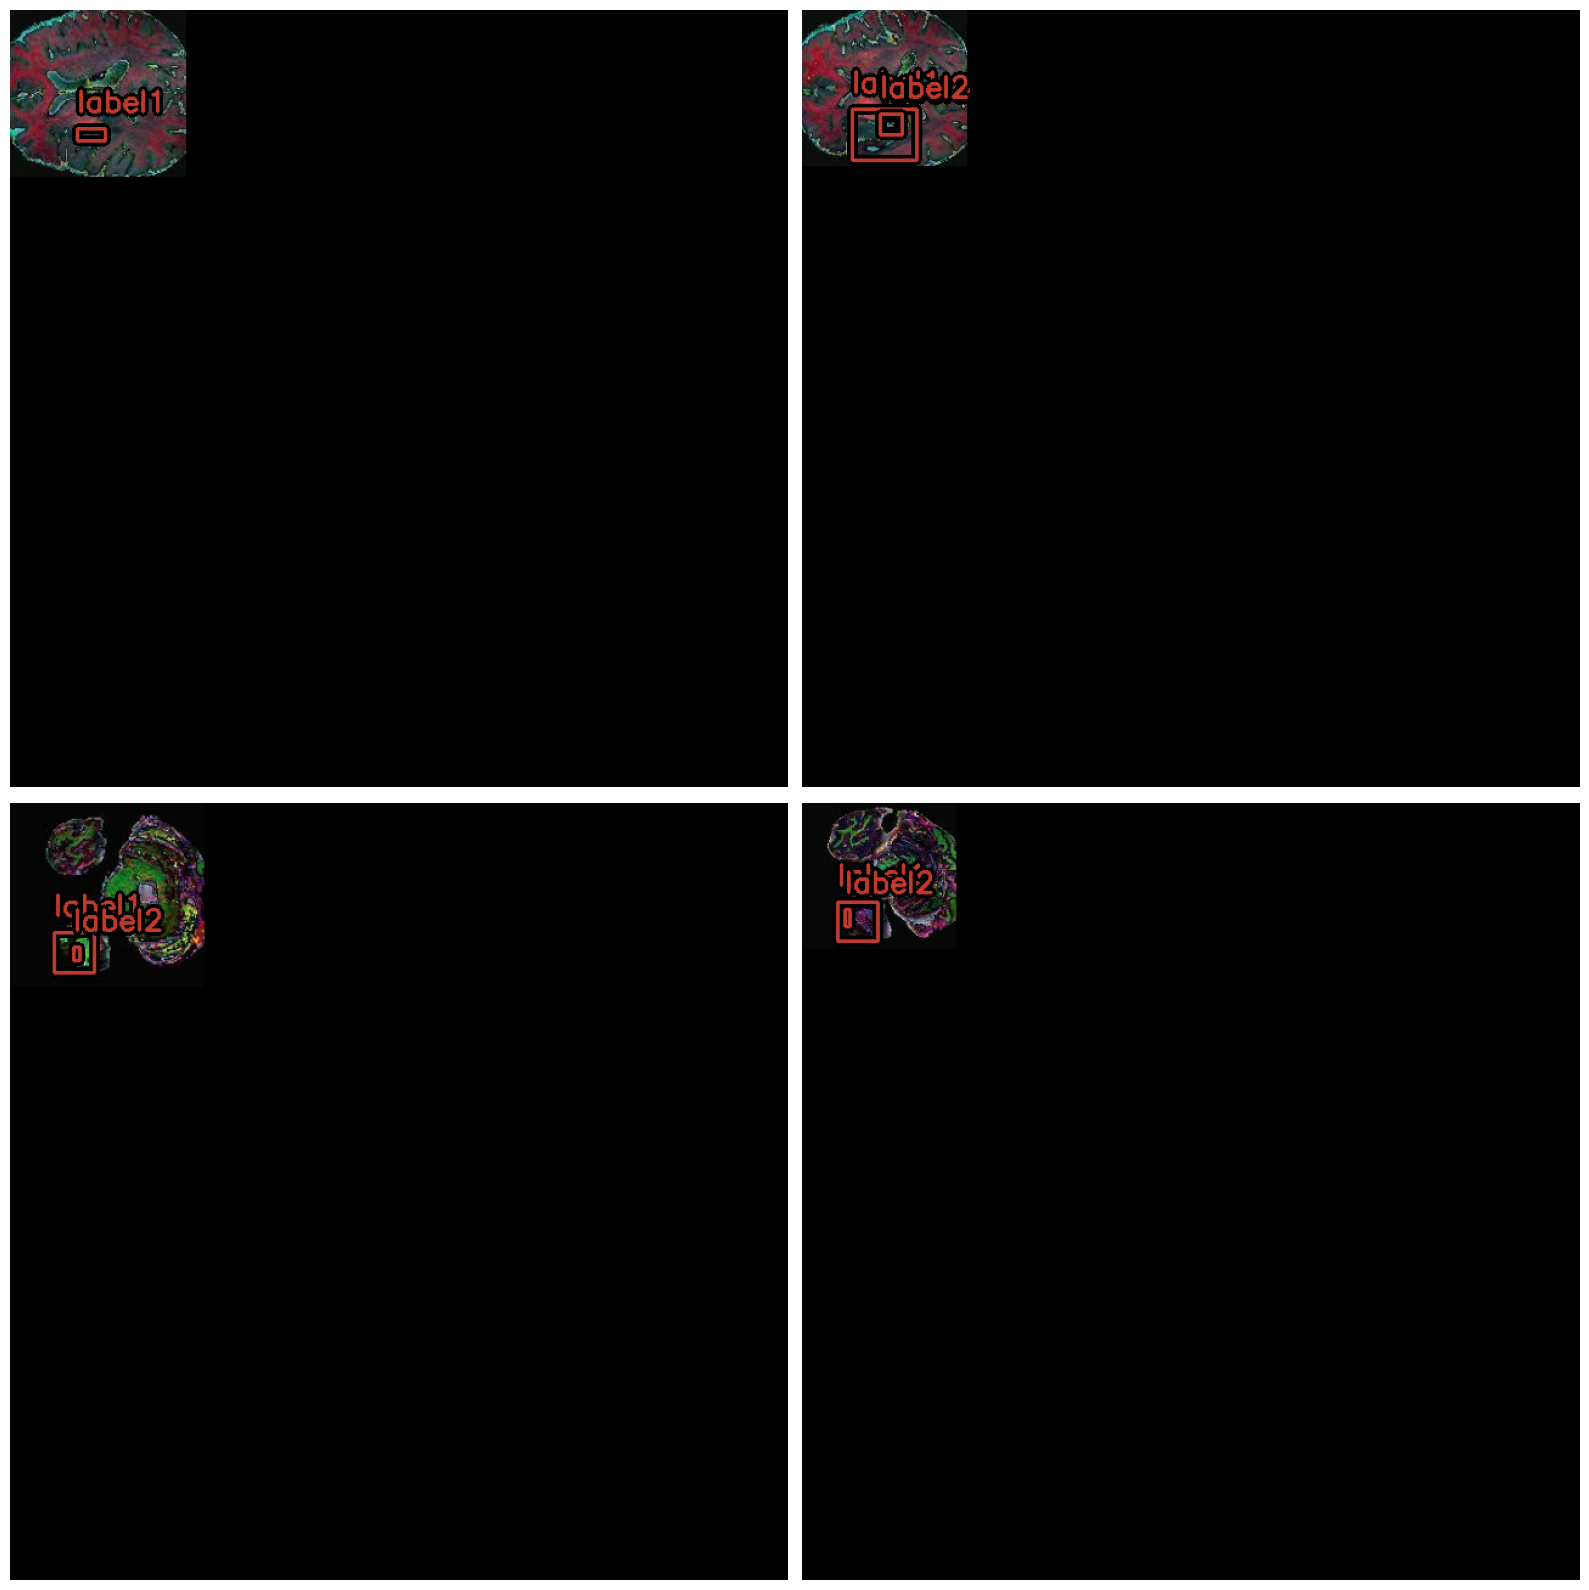

In [8]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

In [9]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

In [10]:
# creating pre-trained model backbone with coco weights

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")
    
    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                              bounding_box_format="xyxy",
                                              backbone=backbone, fpn_depth=1 )

    optimizer = AdamW(learning_rate=0.0001, weight_decay=0.004, global_clipnorm = GLOBAL_CLIPNORM)

    YOLOV8_model.compile(optimizer = optimizer, classification_loss = 'binary_crossentropy', box_loss = 'ciou')

Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_xs_backbone_coco/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_xs_backbone_coco/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/yolov8/keras/yolo_v8_xs_backbone_coco/2' to your Kaggle notebook...
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/opt/conda/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


# <span style="color:#e74c3c;"> Training </span> 

In [11]:
hist = YOLOV8_model.fit(train_dataset, validation_data = valid_dataset,  epochs = 120)

Epoch 1/120
1732/1732 [==============================] - 269s 106ms/step - loss: 888.4286 - box_loss: 5.7938 - class_loss: 882.6357 - val_loss: 85.0413 - val_box_loss: 5.5171 - val_class_loss: 79.5242
Epoch 2/120
1732/1732 [==============================] - 179s 103ms/step - loss: 30.6329 - box_loss: 4.8170 - class_loss: 25.8159 - val_loss: 22.6827 - val_box_loss: 5.0472 - val_class_loss: 17.6354
Epoch 3/120
1732/1732 [==============================] - 178s 102ms/step - loss: 17.5401 - box_loss: 4.4293 - class_loss: 13.1108 - val_loss: 18.6295 - val_box_loss: 4.5235 - val_class_loss: 14.1060
Epoch 4/120
1732/1732 [==============================] - 179s 103ms/step - loss: 15.7402 - box_loss: 4.2223 - class_loss: 11.5180 - val_loss: 17.3942 - val_box_loss: 4.3723 - val_class_loss: 13.0219
Epoch 5/120
1732/1732 [==============================] - 179s 103ms/step - loss: 14.9650 - box_loss: 4.1100 - class_loss: 10.8550 - val_loss: 17.2097 - val_box_loss: 4.3117 - val_class_loss: 12.8980
Epo

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

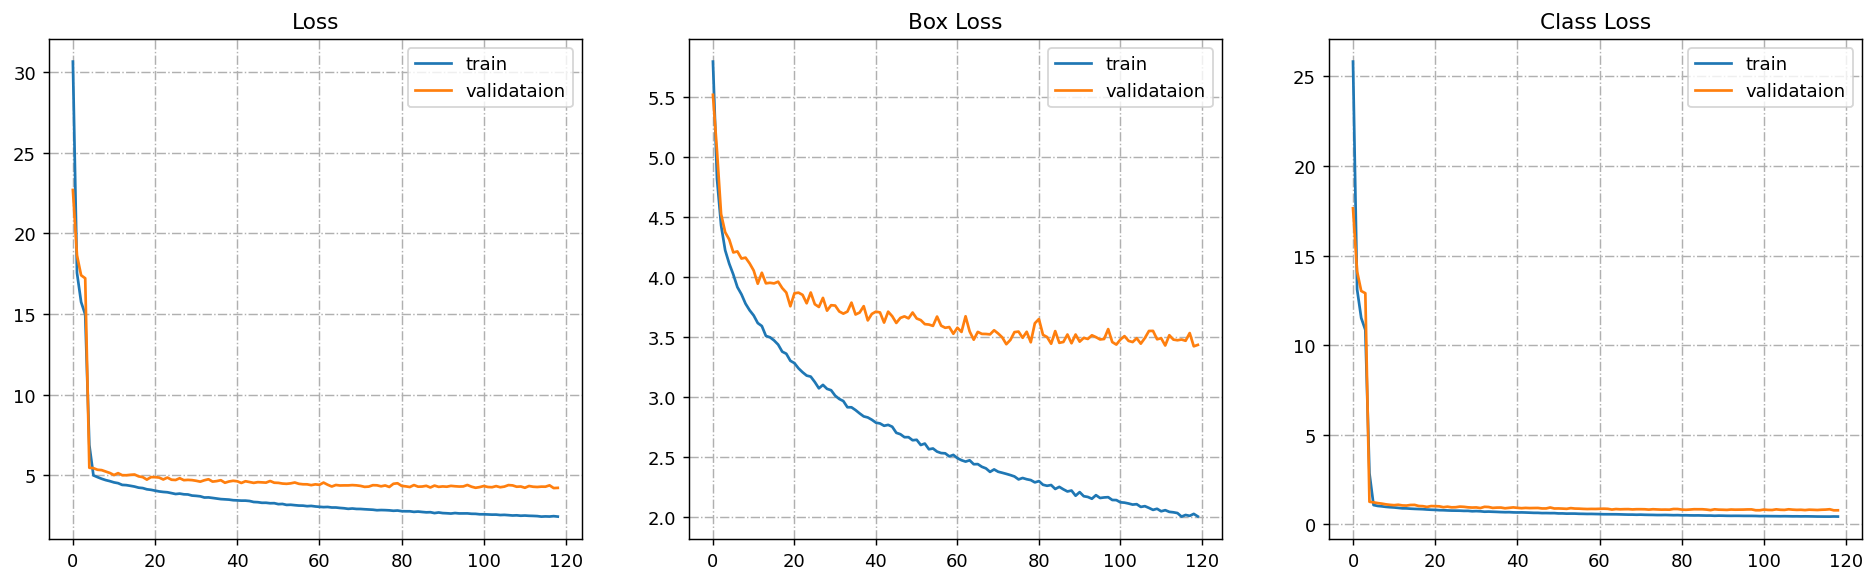

In [12]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][1:])
axs[0].plot(hist.history['val_loss'][1:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][1:])
axs[2].plot(hist.history['val_class_loss'][1:])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [13]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
        
    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

1/1 [==============================] - 10s 10s/step


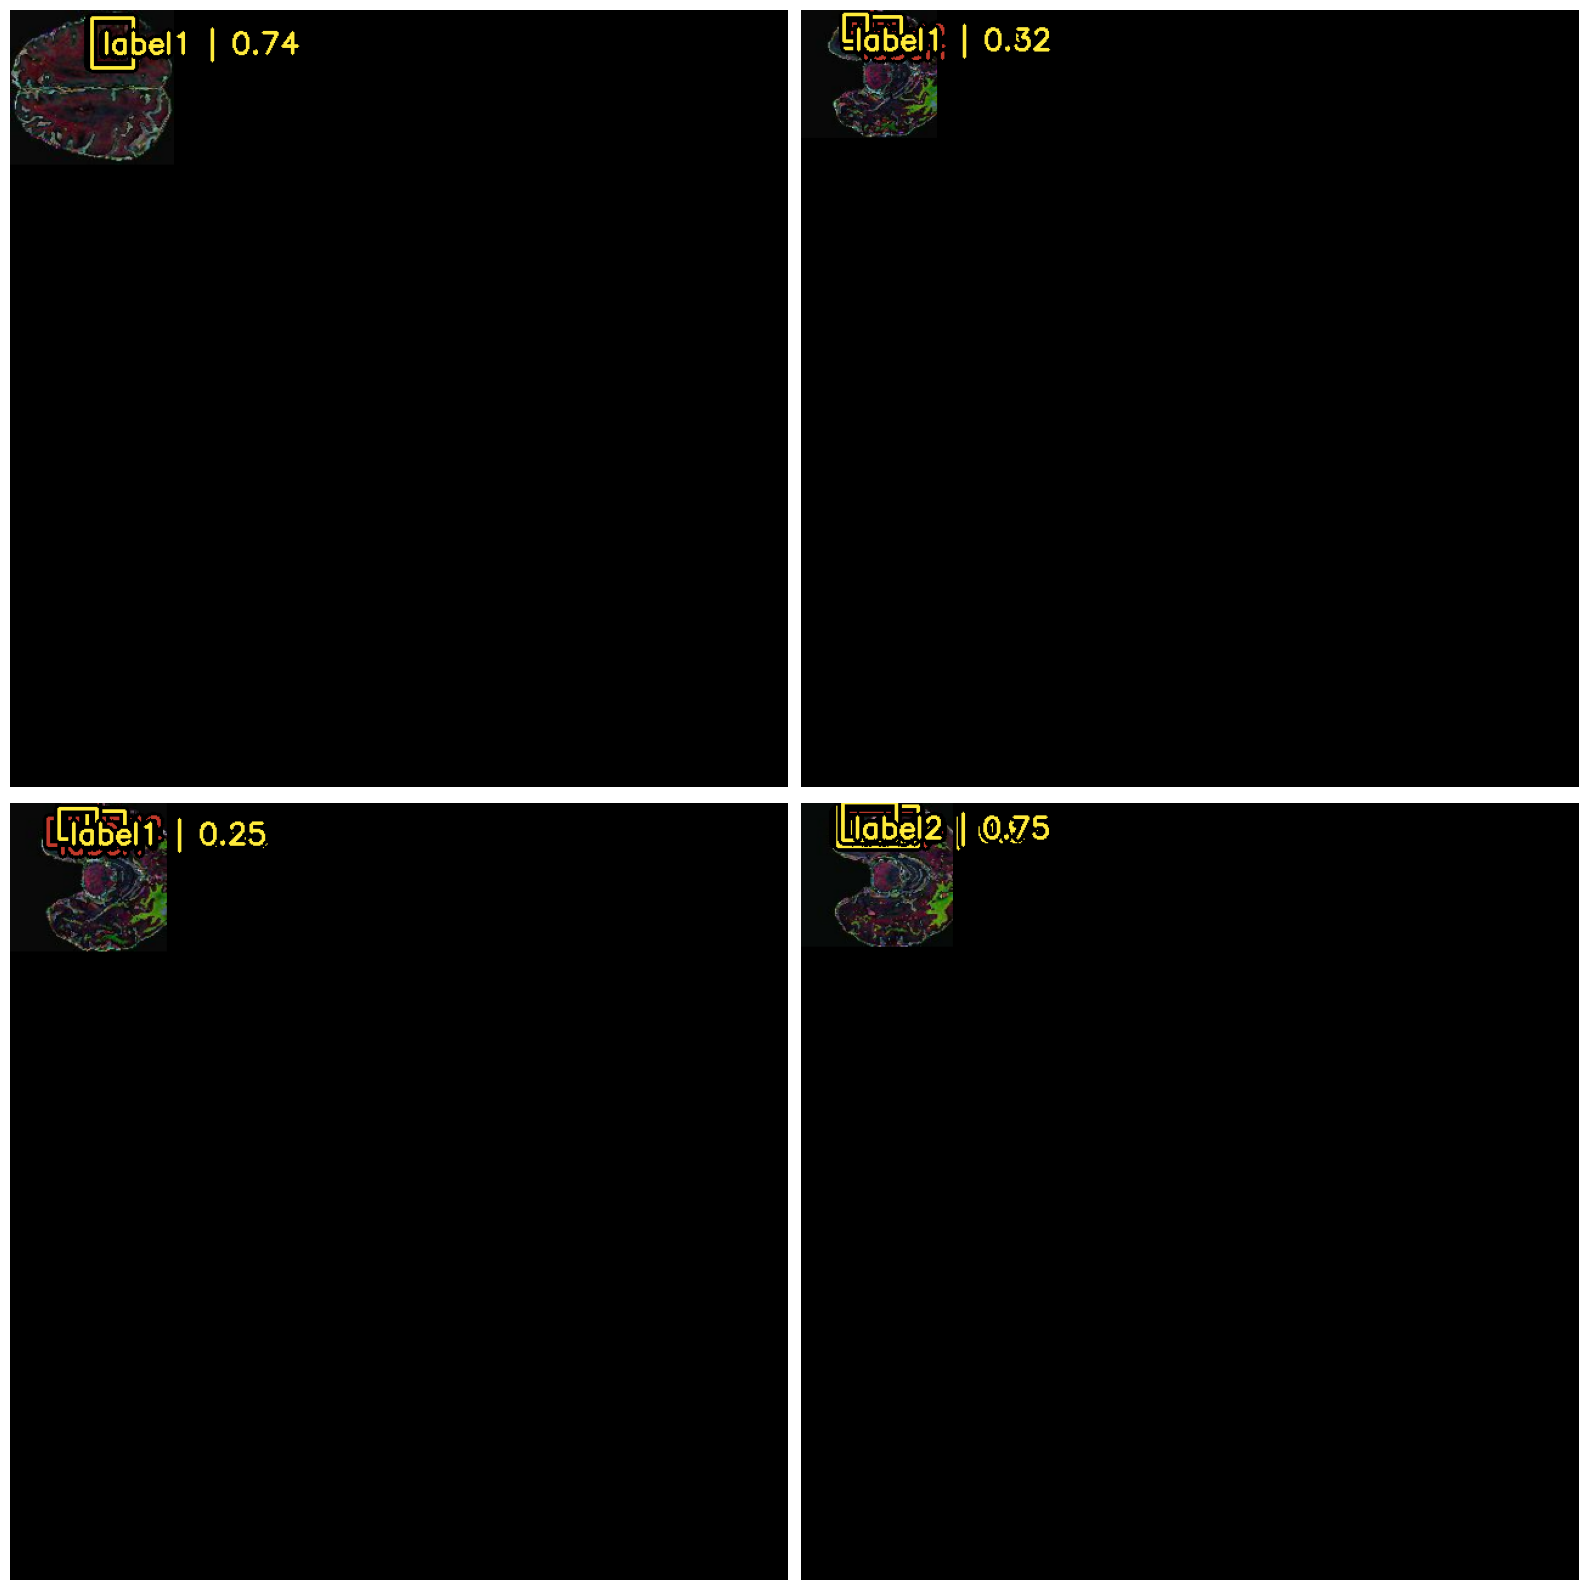

In [14]:
# red -> ground true
# yellow -> prediction

visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")